In [1]:
# %matplotlib notebook
%matplotlib inline
from ipynb_setup import *
import sys
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

import os
import re

In [2]:
from utils.file_utils import get_experiment_df, get_experiment_configs_df
from utils.path_utils import visuals_folder
from plotlib.performance_plots import plot_standard_dev

In [3]:
sns.set_style("whitegrid")

In [136]:
savepath = Path("/home/c817h/Documents/deep-active-plots")
dataset = "CIFAR-100"
folder = "Final"

base_paths = {
    "Cluster" : Path("/home/c817h/network/Cluster-Experiments/activelearning"),
    "Final" : Path("/mnt/drive_nvme2/logs_cluster/activelearning"),
    "Prel" : Path("/mnt/drive_nvme2/rsync_cluster/activelearning"),
}

datasets = {
    "CIFAR-10" : "cifar10",
    "CIFAR-100" : "cifar100",
    "CIFAR-10-LT" : "cifar10_imb",
    "MIO-TCD" : "miotcd",
    "ISIC-2019" : "isic2019"
}



settings = {
    "full" : ["low", "med", "high"],
}

# if "full" in settings:
#     for setting in settings["full"]:
#         settings[setting] = [setting]
    
settings.update({
    "low-bb" : ["low-batchbald"],
    "low-bb-fulll" : ["low-batchbald", "low"],
    "bblow" : ["low"]
})


sub_datasets = {
    "CIFAR-10-LT" : datasets["CIFAR-10"],
    "ISIC-2019" : "isic19"
}

full_models = {
    "CIFAR-10" : {
        "Basic" : "basic_model-resnet_drop-0_aug-cifar_randaugmentMC_wd-0.0005_lr-0.1_optim-sgd_cosine",
        "PT" : None,
    },
    "CIFAR-100" : {
        "Basic" :"basic_model-resnet_drop-0_aug-cifar_randaugmentMC_wd-0.005_lr-0.1_optim-sgd_cosine",
        "PT" : None,
    },
    "CIFAR-10-LT" :{
        "Basic" : "basic_model-resnet_drop-0_aug-cifar_randaugmentMC_wd-0.0005_lr-0.1_optim-sgd_cosine_weighted-true",
        "PT" : None,
    },
    "MIO-TCD" : {
        "Basic" : "basic_model-resnet_drop-0_aug-imagenet_randaugMC_wd-5e-05_lr-0.1_optim-sgd_cosine_weighted-True_epochs-80",
        "PT" : None,
    },
    "ISIC-2019" : {
        "Basic" : "basic_model-resnet_drop-0_aug-isic_train_wd-0.005_lr-0.01_optim-sgd_cosine_weighted-True_epochs-200",
        "PT" : None
    },
}

base_path = base_paths[folder]
d_set = datasets[dataset]


fill_set = d_set
if dataset in sub_datasets:
    fill_set = sub_datasets[dataset]

    
for setting in settings:
#     print(settings[setting])
    settings[setting] = [f"active-{fill_set}_{exp}" for exp in settings[setting]]



In [137]:
setting_paths = {}

for setting in settings:
    setting_paths[setting] = [base_path / d_set / exp for exp in settings[setting]]
    
# print(dataset)
full_paths = {}
for model in full_models[dataset]:
    if full_models[dataset][model] is not None:
        full_paths[model] = base_path / d_set / "full_data" / full_models[dataset][model]

from pprint import pprint  
pprint(setting_paths)
print(full_paths)

{'bblow': [PosixPath('/mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low')],
 'full': [PosixPath('/mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low'),
          PosixPath('/mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_med'),
          PosixPath('/mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_high')],
 'low-bb': [PosixPath('/mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low-batchbald')],
 'low-bb-fulll': [PosixPath('/mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low-batchbald'),
                  PosixPath('/mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low')]}
{'Basic': PosixPath('/mnt/drive_nvme2/logs_cluster/activelearning/cifar100/full_data/basic_model-resnet_drop-0_aug-cifar_randaugmentMC_wd-0.005_lr-0.1_optim-sgd_cosine')}


In [138]:
match_patterns = [
    r"basic_.*",
    r"basic-pretrained_.*",
#     r".*__wloss.*"
#     BB experiment
#     r".*bald.*"
#     r".*random.*"
    r"fixmatch_.*",
#     r"fixmatch-pretrained_.*",
]

filter_dict = {
    "standard": [
        ".*batchbald.*"
    ],
    "bb" : [
        
    ]
}
# filter_patterns = [
    
# #     r".*batchbald.*"
# #     ".*wd-0.01_.*"
# #     r".*kcenter.*",
# #     r".*variationratios.*"
# #     r".*batchbald.*"
# #     r".*basic-pretrained_.*",
# ]

In [139]:
hue_name = "Acquisition"

hue_split = "acq-"

style_name = "PreTraining & Semi-Supervised"
style_fct = lambda x: "PT: {}, Sem-SL: {}".format(
    "pretrained_model" in x.name,
    "fixmatch" in x.name
)

unit_vals = None
unit_name = "Unit"

palette = {
    'bald': 'tab:blue',
    'kcentergreedy': 'tab:green',
    'entropy': 'tab:orange',
    'random': 'tab:red',
    'batchbald' : 'tab:cyan'
}

# Sadly does not Work!
# dashes = {
#     'PT: False, Sem-SL: False' : '--',
#     'PT: True, Sem-SL: False' : '-',
#     'PT: False, Sem-SL: True' : ':',
#     'PT: True, Sem-SL: True' : '-.',
# }

dashes = {
    'PT: False, Sem-SL: False' : (4, 4),
    'PT: True, Sem-SL: False' : (1, 0),
    'PT: False, Sem-SL: True' : (1, 2),
    'PT: True, Sem-SL: True' : (2, 1),
}

markers= True
# no color
# markers = {
#     'PT: False, Sem-SL: False' : "x",
#     'PT: True, Sem-SL: False' : "+",
#     'PT: False, Sem-SL: True' : "1",
#     'PT: True, Sem-SL: True' : "2",
# }

markers = {
    'PT: False, Sem-SL: False' : "v",
    'PT: True, Sem-SL: False' : "o",
    'PT: False, Sem-SL: True' : "D",
    'PT: True, Sem-SL: True' : "X",
}

err_kws = {
    "alpha" : 0.3
}

In [140]:
training_settings = {
    "all" : ['PT: False, Sem-SL: False', 'PT: True, Sem-SL: False', 'PT: False, Sem-SL: True', 'PT: True, Sem-SL: True'],
    "basic" : ['PT: False, Sem-SL: False'],
    "Self-SL" : ['PT: True, Sem-SL: False'],
    "Sem-SL" : ['PT: False, Sem-SL: True'],
    "Self-Sem-SL" : ['PT: True, Sem-SL: True'],
}

In [141]:
setting_dfs = dict()
for setting in setting_paths:
    base_paths = setting_paths[setting]
    if not all(base_path.is_dir() for base_path in base_paths):
        print(f"Skipping Setting: {setting}\nPath is not existent {base_path}")
        continue
    key_filter = "standard"
    for key in filter_dict:
        if key in setting:
            key_filter = key
    if key is None:
        key_filter = "standard"
    print("Selecting Filter Pattern from {}".format(key_filter))
    filter_patterns = filter_dict[key_filter]
    dfs = []
#     print(base_paths)


    for base_path in base_paths:
        paths = [path for path in base_path.iterdir() if path.is_dir()]
        paths.sort()
        print("Folders in Path: \n {}\n".format(base_path))


        experiment_paths = []
        for path in paths:
    #         print(path)
            for pattern in match_patterns:
    #             print(path.name)
                out = re.match(pattern, str(path.name))
                if out is not None:
                    print(path.name)
                    skip = False
                    for filter_pattern in filter_patterns:
                        if re.match(filter_pattern, str(path)) is not None:
                            skip=True
                    if skip:
                        continue

                    print(path.name)
                    experiment_paths.append(path)
                    continue



        hue_names = [path.name.split(hue_split)[1].split('_')[0] for path in experiment_paths]#.split('_')[0] for path in paths]
        style_vals = [style_fct(path) for path in experiment_paths]


        df = []
        for i, (base_dir) in enumerate(experiment_paths):
            base_dir = Path(base_dir)
            if hue_names is not None:
                hue_val = hue_names[i]
            else:
                hue_val = None
            if style_vals is not None:
                style_val = style_vals[i]
            else:
                style_val = None
            if unit_vals is not None:
                unit_val = unit_vals[i]
            else:
                unit_val = None

            experiment_frame = get_experiment_df(base_dir, name=hue_val)
            # experiment_frame[hue_name] = hue_val
            if experiment_frame is None:
                continue

            # Add new metric values
            experiment_add = get_experiment_df(base_dir, pattern="test_metrics.csv", name=hue_val)
    #         print(experiment_add)
            if experiment_add is not None:
    #             print(experiment_frame)
    #             print(experiment_add)
                del experiment_add["Name"]
                del experiment_add["version"]
                experiment_frame = experiment_frame.join(experiment_add)
    #             print(experiment_frame)


            experiment_frame[hue_name] = hue_val
            experiment_frame[style_name] = style_val
            experiment_frame[unit_name] = unit_val
            df.append(experiment_frame)
        df = pd.concat(df)
        df.reset_index(inplace=True)

        dfs.append(df)
        setting_dfs[setting] = dfs

Selecting Filter Pattern from standard
Folders in Path: 
 /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low

basic-pretrained_model-resnet_drop-0.5_aug-cifar_randaugment_acq-bald_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0.5_aug-cifar_randaugment_acq-bald_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0.5_aug-cifar_randaugment_acq-batchbald_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-kcentergreedy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-kcentergreedy_ep-80_freeze-False_smallhead-False
basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-random_ep-80_freeze-False_smallhead-False
basic-

Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_med/basic-pretrained_model-resnet_drop-0.5_aug-cifar_randaugment_acq-bald_ep-80_freeze-False_smallhead-False
Found num files: 3
Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_med/basic-pretrained_model-resnet_drop-0.5_aug-cifar_randaugment_acq-bald_ep-80_freeze-False_smallhead-False
Found num files: 3
Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_med/basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
Found num files: 3
Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_med/basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
Found num files: 3
Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_med/basic-pretrained_model-resnet_dr

Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_high/basic_model-resnet_drop-0_aug-cifar_randaugmentMC_acq-kcentergreedy_ep-200
Found num files: 3
Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_high/basic_model-resnet_drop-0_aug-cifar_randaugmentMC_acq-kcentergreedy_ep-200
Found num files: 3
Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_high/basic_model-resnet_drop-0_aug-cifar_randaugmentMC_acq-random_ep-200
Found num files: 3
Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_high/basic_model-resnet_drop-0_aug-cifar_randaugmentMC_acq-random_ep-200
Found num files: 3
Selecting Filter Pattern from bb
Folders in Path: 
 /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low-batchbald

basic-pretrained_model-resnet_drop-0.5_aug-cifar_randaugment_acq-bald_ep-80_freeze-False_smallhead-False
basic-pretrained

Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low/basic-pretrained_model-resnet_drop-0.5_aug-cifar_randaugment_acq-batchbald_ep-80_freeze-False_smallhead-False
Found num files: 3
Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low/basic-pretrained_model-resnet_drop-0.5_aug-cifar_randaugment_acq-batchbald_ep-80_freeze-False_smallhead-False
Found num files: 3
Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low/basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
Found num files: 3
Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low/basic-pretrained_model-resnet_drop-0_aug-cifar_randaugment_acq-entropy_ep-80_freeze-False_smallhead-False
Found num files: 3
Loading Experiment: /mnt/drive_nvme2/logs_cluster/activelearning/cifar100/active-cifar100_low/basic-pretrained_model

In [142]:
full_data_dict = {}

for key, path in full_paths.items():
    test_acc_df = pd.read_csv(path/"test_acc.csv", index_col=0)
    full_data_dict[key] = dict()
    full_data_dict[key]["test_acc"]=dict()
    full_data_dict[key]["test_acc"]["mean"] = float(test_acc_df["Mean"])
    full_data_dict[key]["test_acc"]["std"] =  float(test_acc_df["STD"])
    
    if (path/"test_w_acc.csv").is_file():
        mean_recall_df = pd.read_csv(path/"test_w_acc.csv", index_col=0)
        full_data_dict[key]["test/w_acc"]=dict()
        full_data_dict[key]["test/w_acc"]["mean"] = float(mean_recall_df["Mean"])
        full_data_dict[key]["test/w_acc"]["std"] =  float(mean_recall_df["STD"])

Filename:plot-full_train-all.pdf


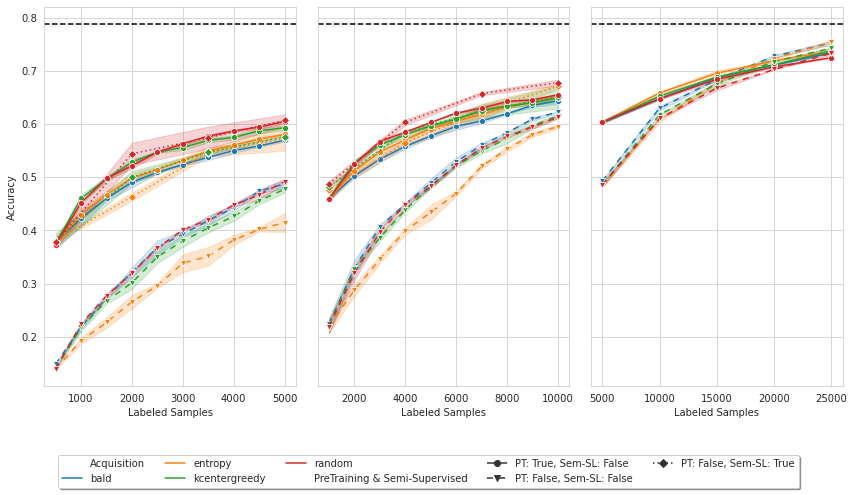

Filename:plot-full_train-basic.pdf


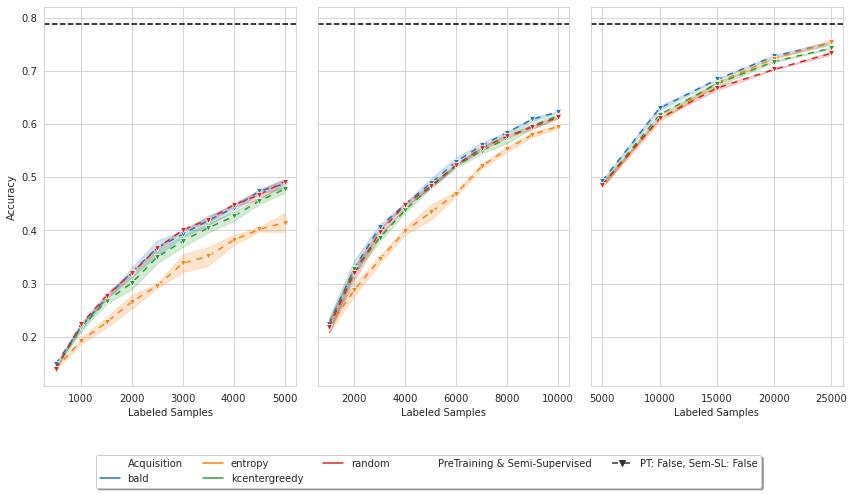

Filename:plot-full_train-Self-SL.pdf


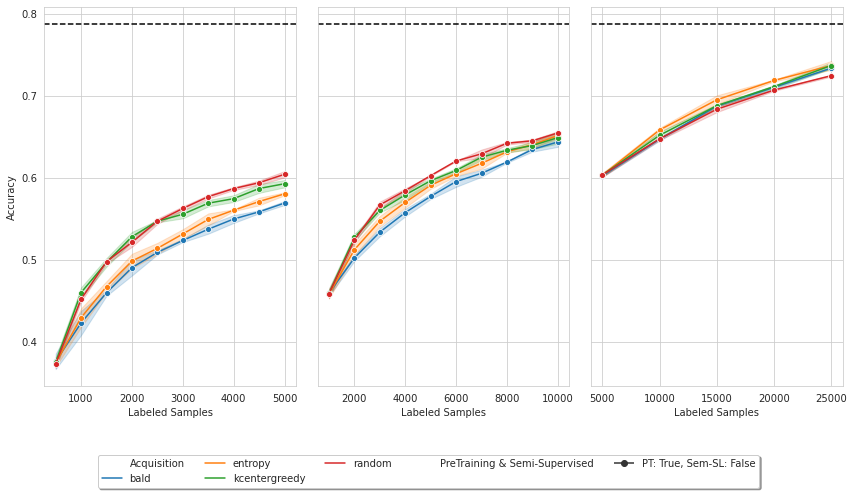

Filename:plot-full_train-Sem-SL.pdf


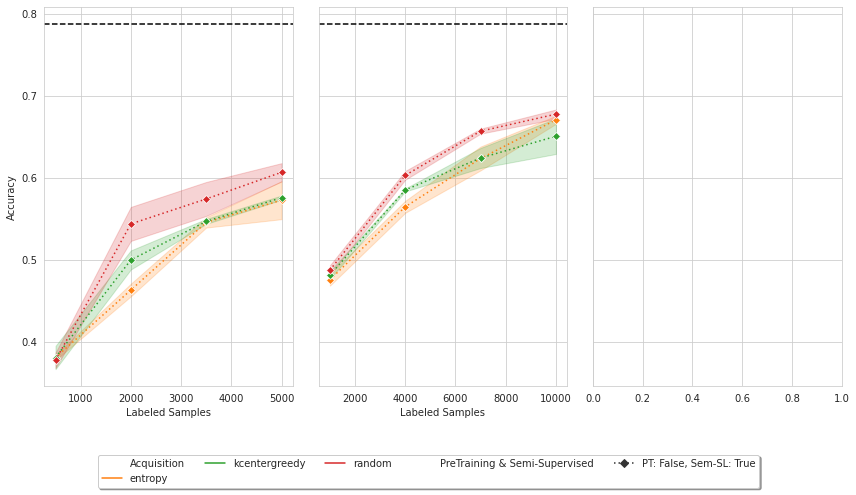

No handles with labels found to put in legend.


Filename:plot-full_train-Self-Sem-SL.pdf


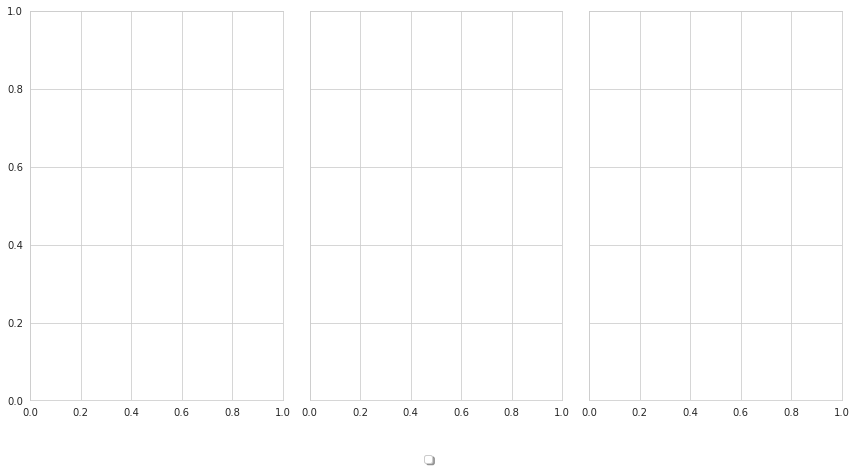

Filename:plot-low-bb_train-all.pdf


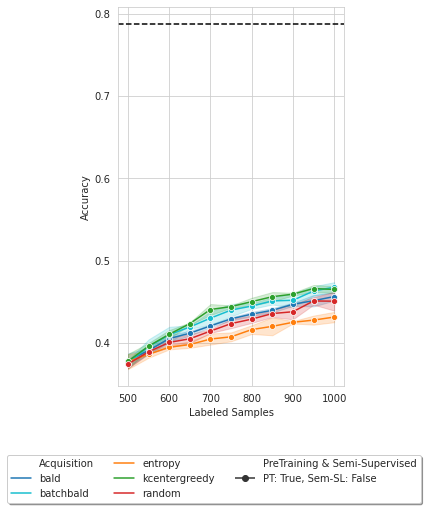

No handles with labels found to put in legend.


Filename:plot-low-bb_train-basic.pdf


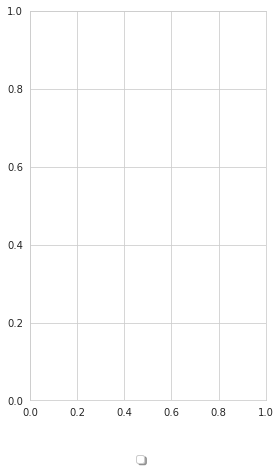

Filename:plot-low-bb_train-Self-SL.pdf


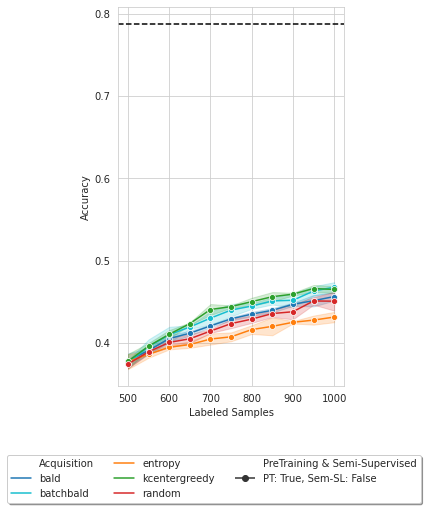

No handles with labels found to put in legend.


Filename:plot-low-bb_train-Sem-SL.pdf


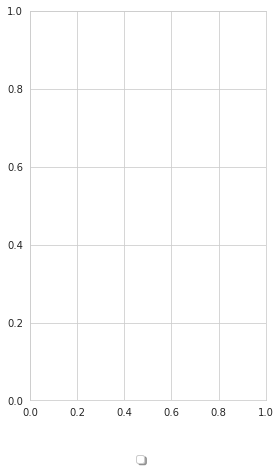

No handles with labels found to put in legend.


Filename:plot-low-bb_train-Self-Sem-SL.pdf


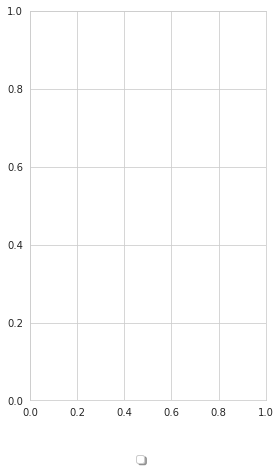

Filename:plot-low-bb-fulll_train-all.pdf


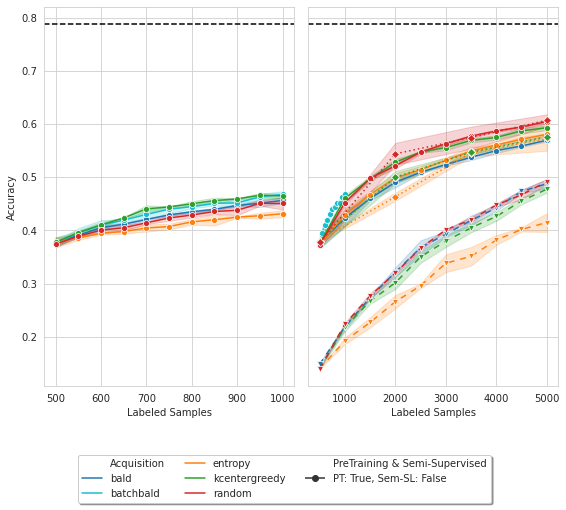

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-basic.pdf


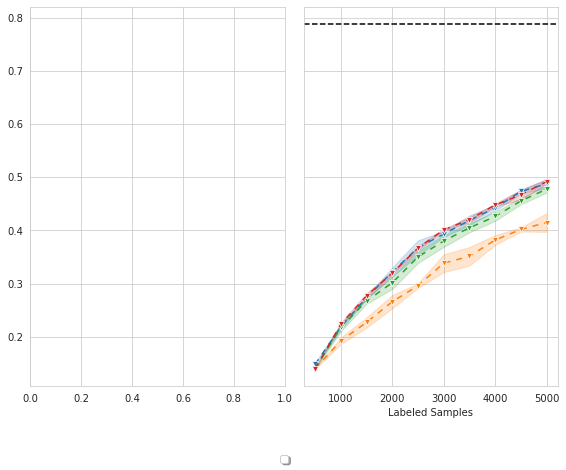

Filename:plot-low-bb-fulll_train-Self-SL.pdf


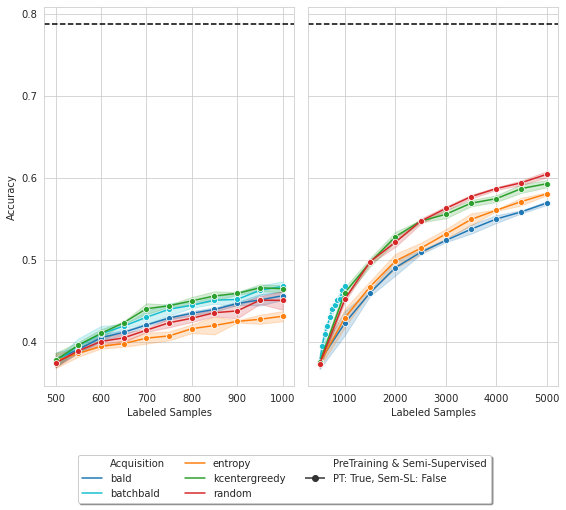

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-Sem-SL.pdf


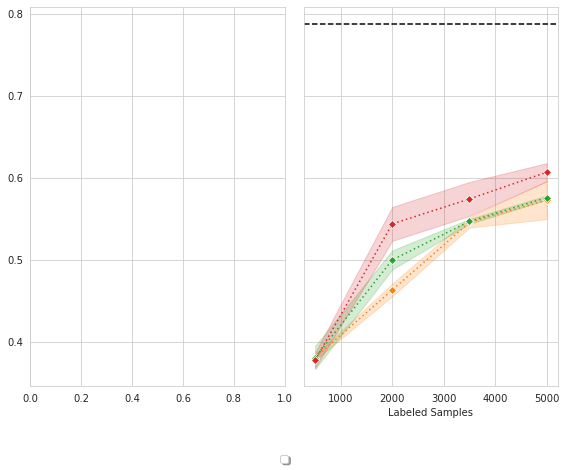

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-Self-Sem-SL.pdf


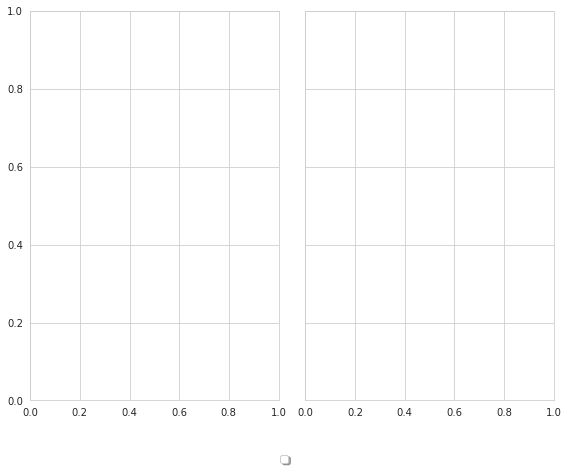

Filename:plot-bblow_train-all.pdf


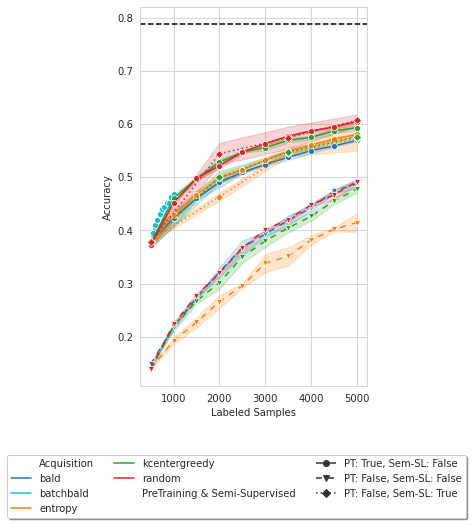

Filename:plot-bblow_train-basic.pdf


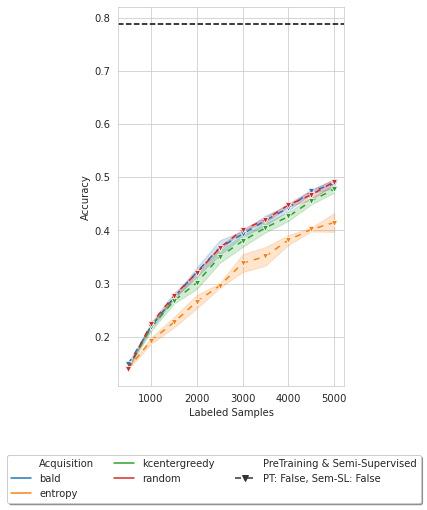

Filename:plot-bblow_train-Self-SL.pdf


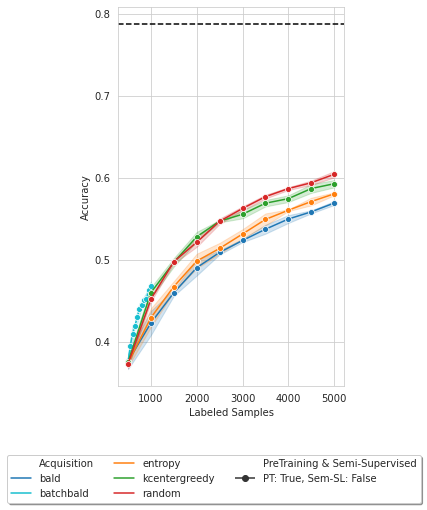

Filename:plot-bblow_train-Sem-SL.pdf


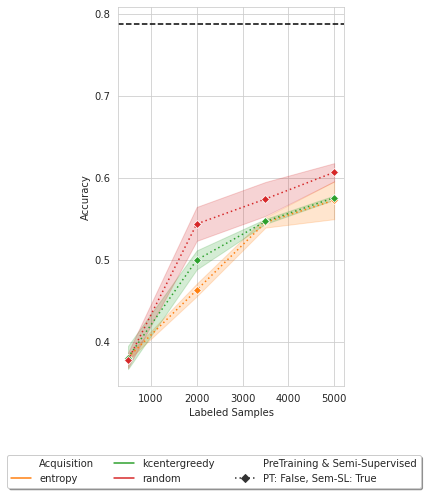

No handles with labels found to put in legend.


Filename:plot-bblow_train-Self-Sem-SL.pdf


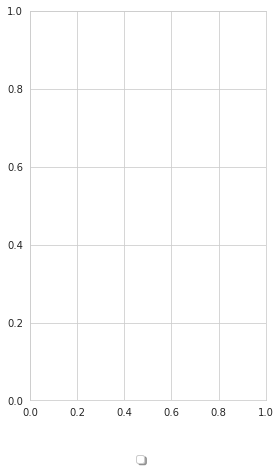

Filename:plot-full_train-all.pdf


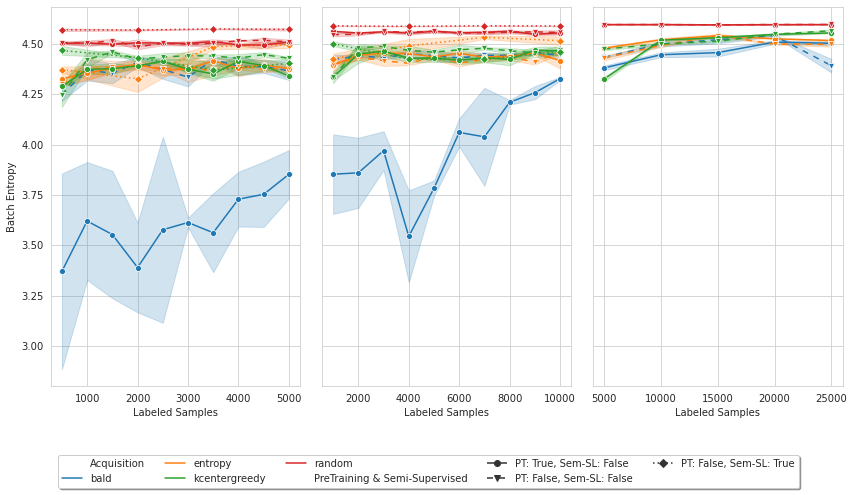

Filename:plot-full_train-basic.pdf


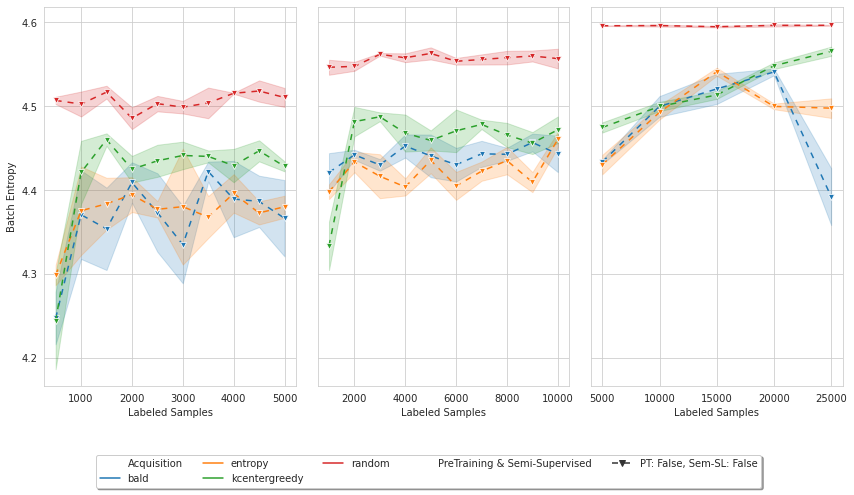

Filename:plot-full_train-Self-SL.pdf


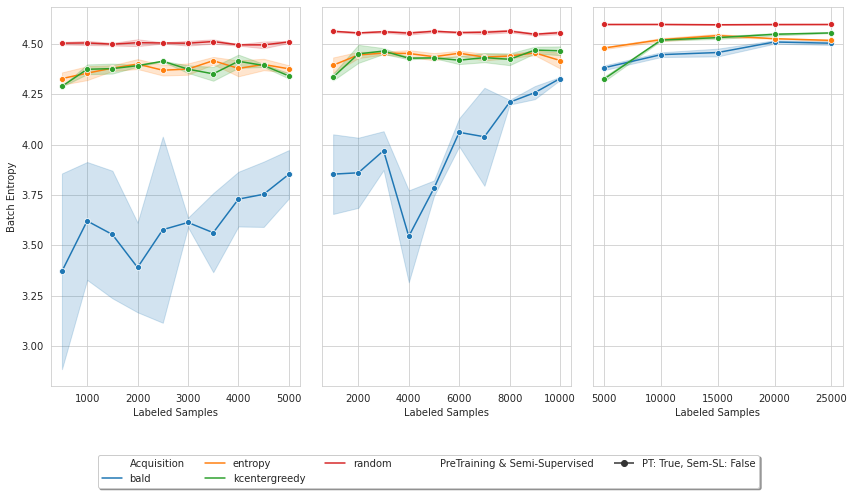

Filename:plot-full_train-Sem-SL.pdf


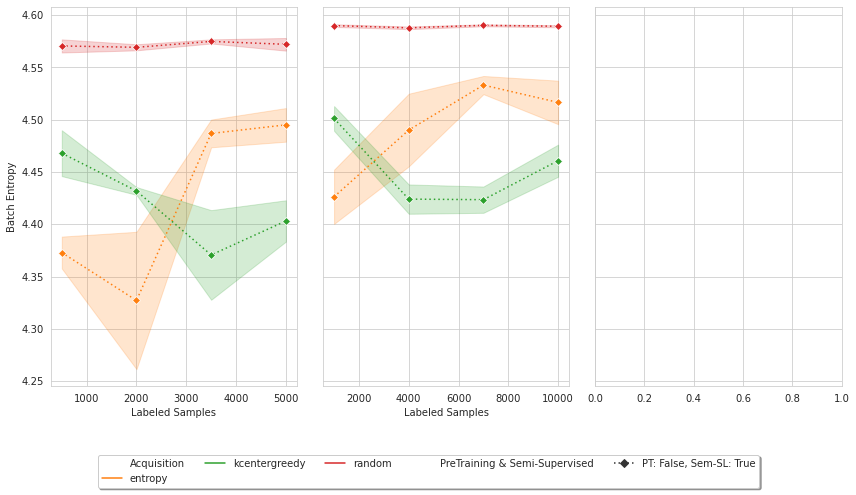

No handles with labels found to put in legend.


Filename:plot-full_train-Self-Sem-SL.pdf


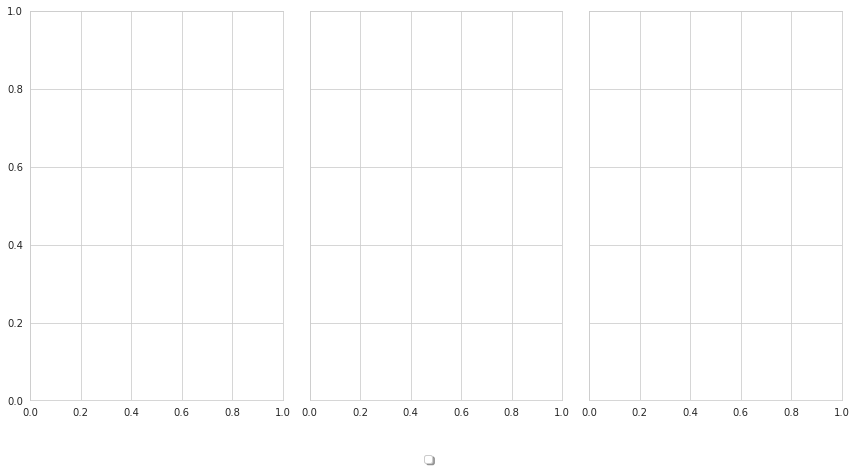

Filename:plot-low-bb_train-all.pdf


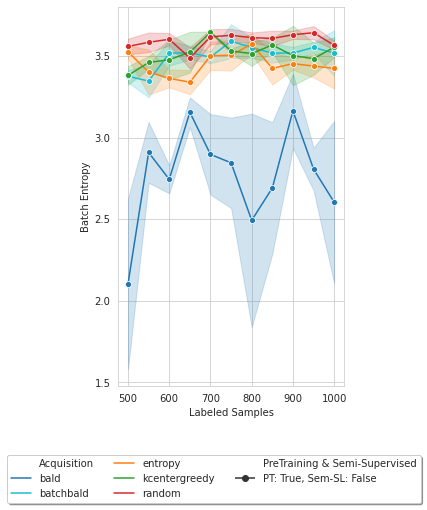

No handles with labels found to put in legend.


Filename:plot-low-bb_train-basic.pdf


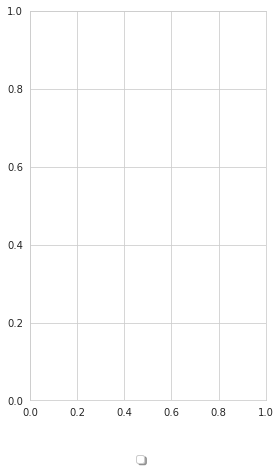

Filename:plot-low-bb_train-Self-SL.pdf


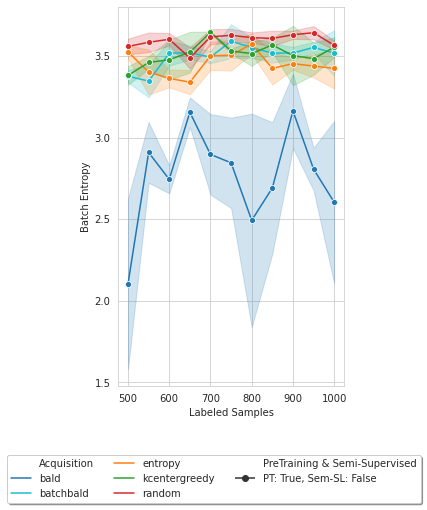

No handles with labels found to put in legend.


Filename:plot-low-bb_train-Sem-SL.pdf


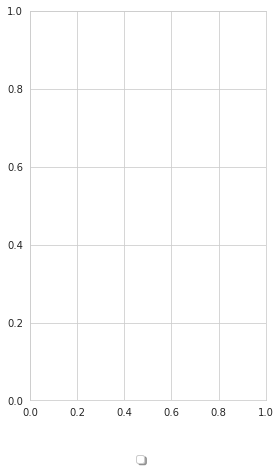

No handles with labels found to put in legend.


Filename:plot-low-bb_train-Self-Sem-SL.pdf


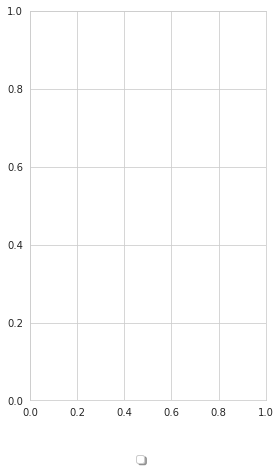

Filename:plot-low-bb-fulll_train-all.pdf


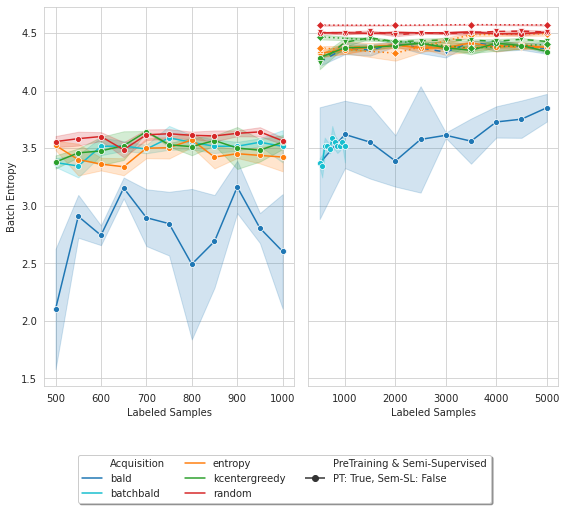

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-basic.pdf


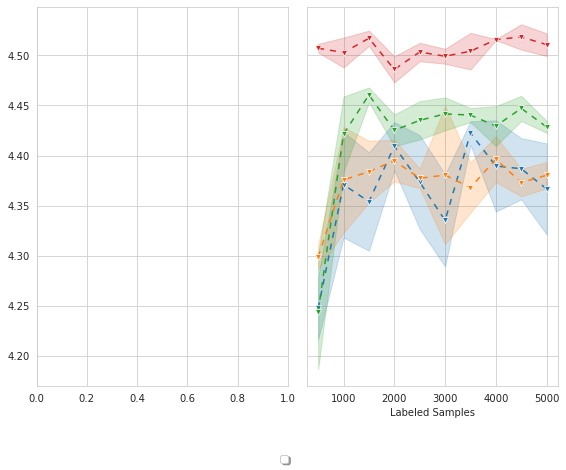

Filename:plot-low-bb-fulll_train-Self-SL.pdf


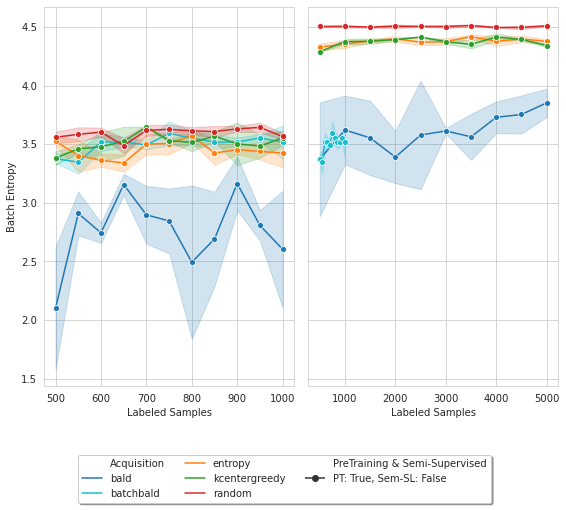

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-Sem-SL.pdf


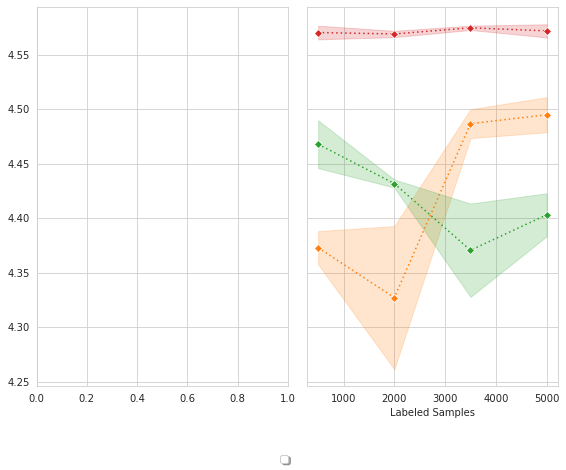

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-Self-Sem-SL.pdf


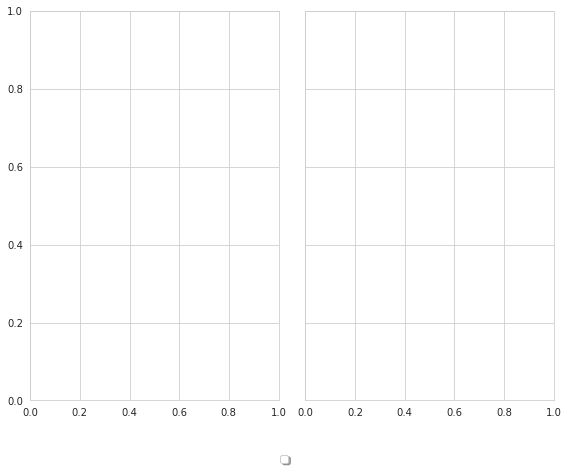

Filename:plot-bblow_train-all.pdf


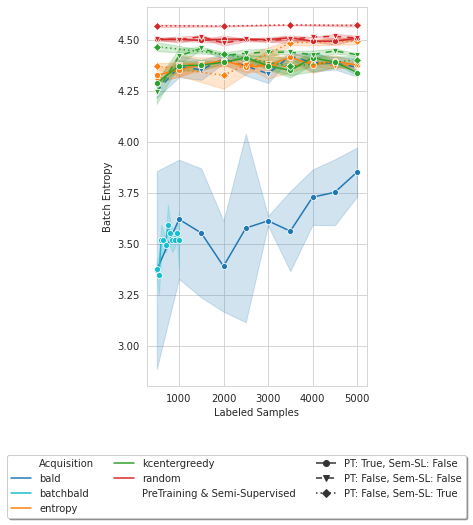

Filename:plot-bblow_train-basic.pdf


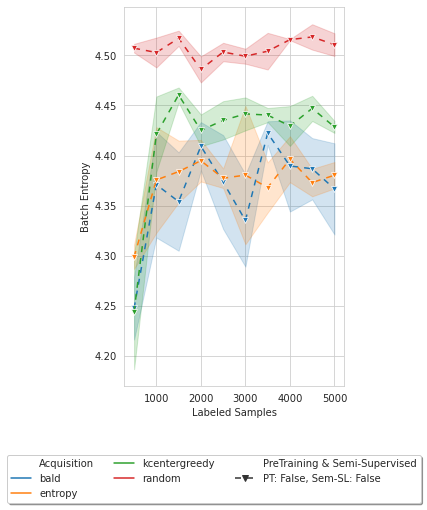

Filename:plot-bblow_train-Self-SL.pdf


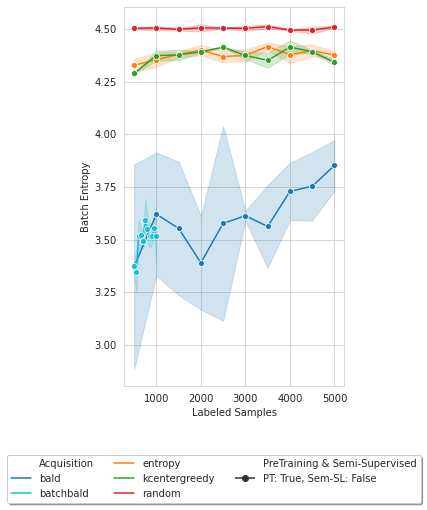

Filename:plot-bblow_train-Sem-SL.pdf


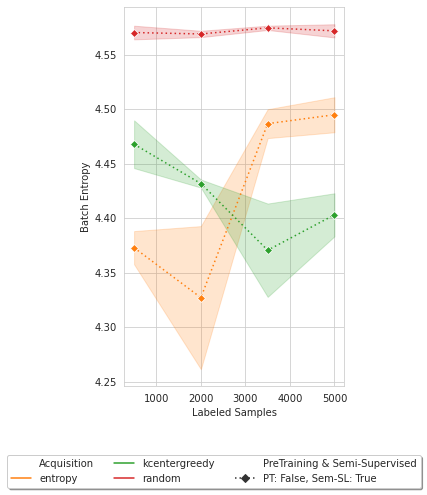

No handles with labels found to put in legend.


Filename:plot-bblow_train-Self-Sem-SL.pdf


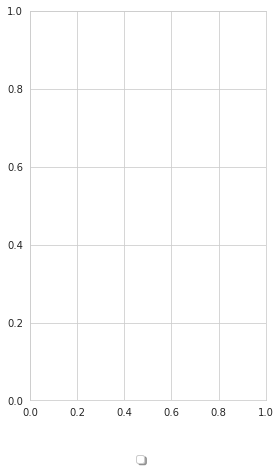

Filename:plot-full_train-all.pdf


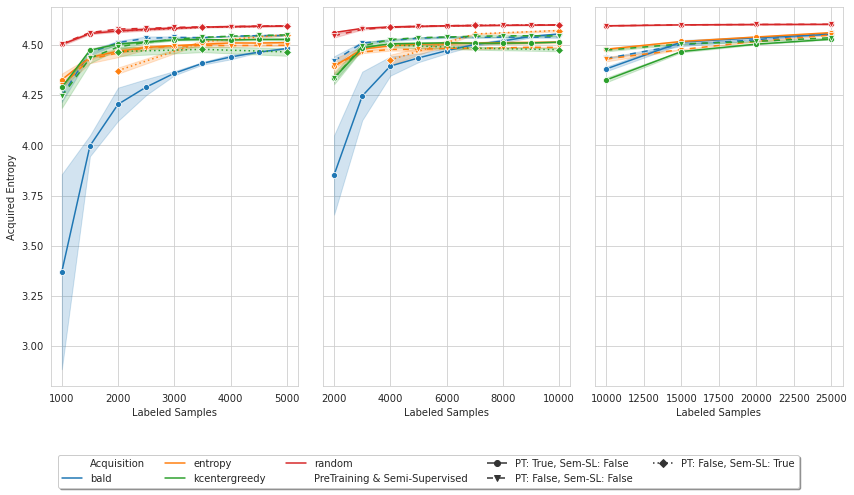

Filename:plot-full_train-basic.pdf


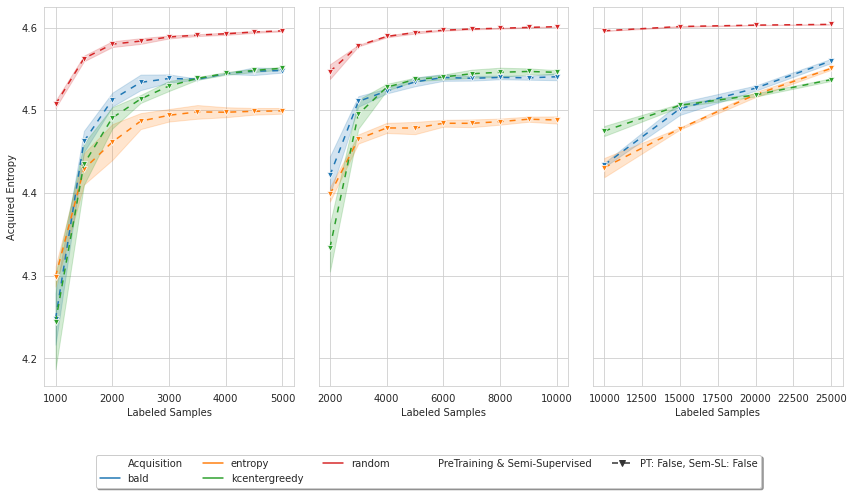

Filename:plot-full_train-Self-SL.pdf


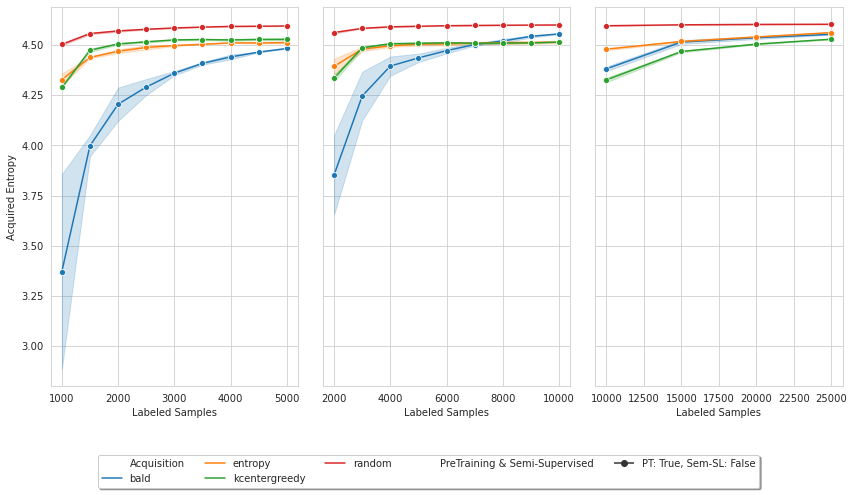

Filename:plot-full_train-Sem-SL.pdf


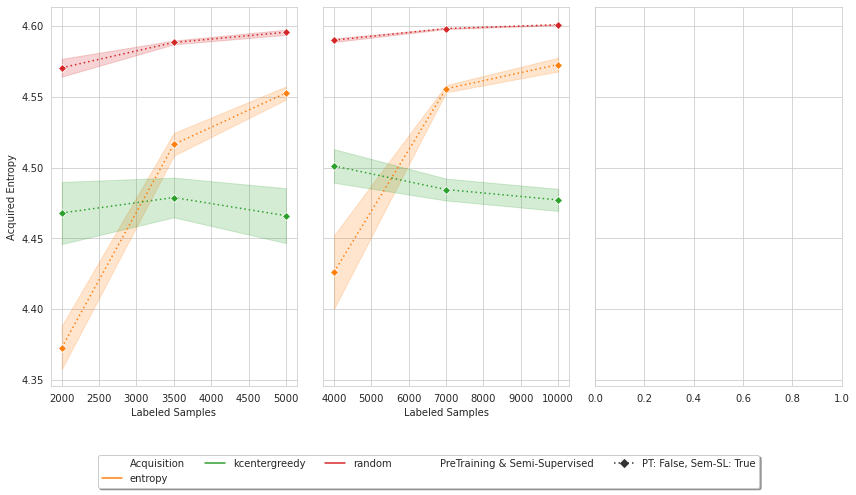

No handles with labels found to put in legend.


Filename:plot-full_train-Self-Sem-SL.pdf


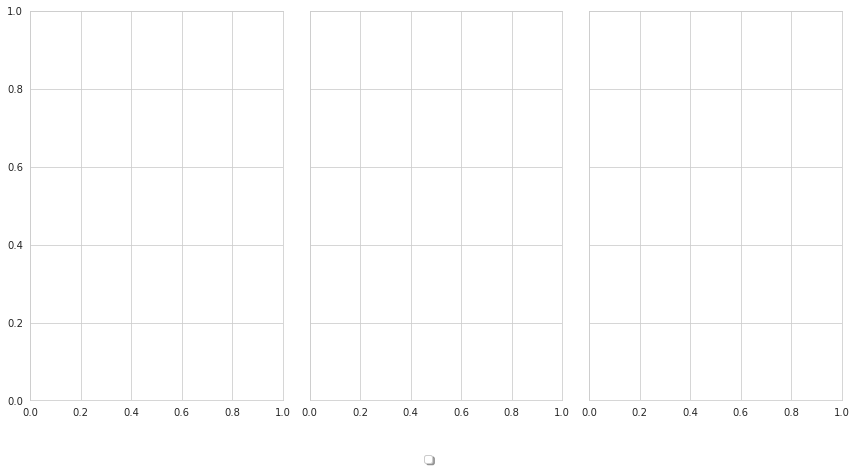

Filename:plot-low-bb_train-all.pdf


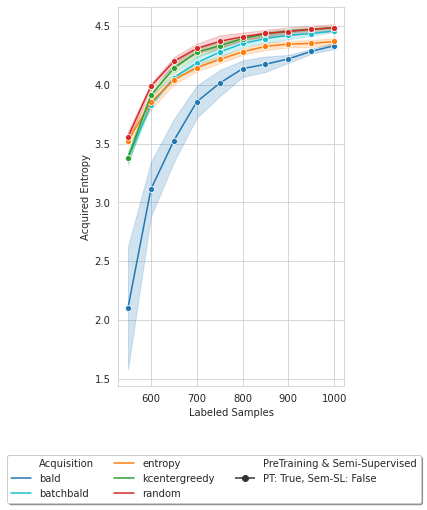

No handles with labels found to put in legend.


Filename:plot-low-bb_train-basic.pdf


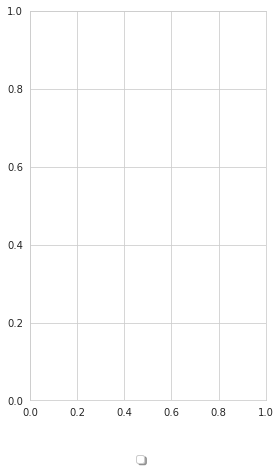

Filename:plot-low-bb_train-Self-SL.pdf


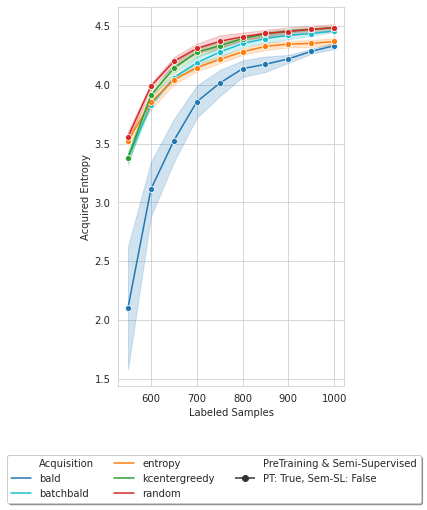

No handles with labels found to put in legend.


Filename:plot-low-bb_train-Sem-SL.pdf


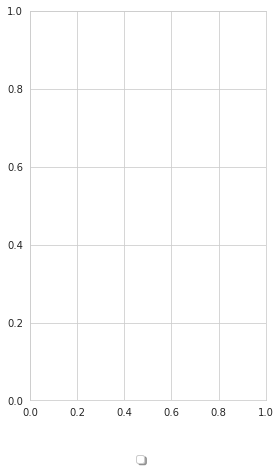

No handles with labels found to put in legend.


Filename:plot-low-bb_train-Self-Sem-SL.pdf


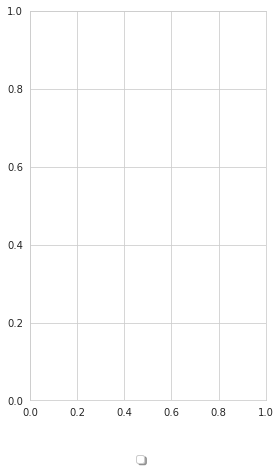

Filename:plot-low-bb-fulll_train-all.pdf


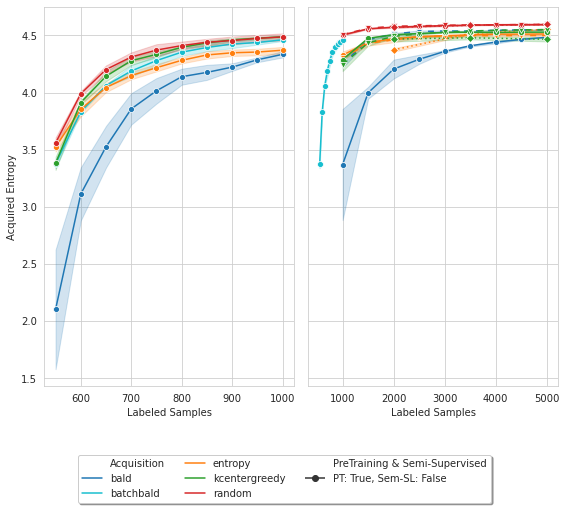

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-basic.pdf


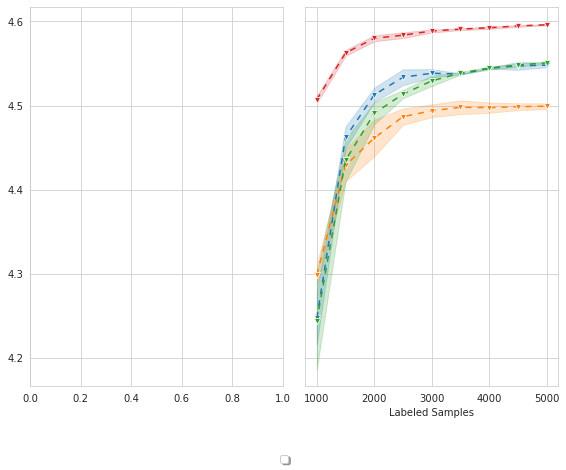

Filename:plot-low-bb-fulll_train-Self-SL.pdf


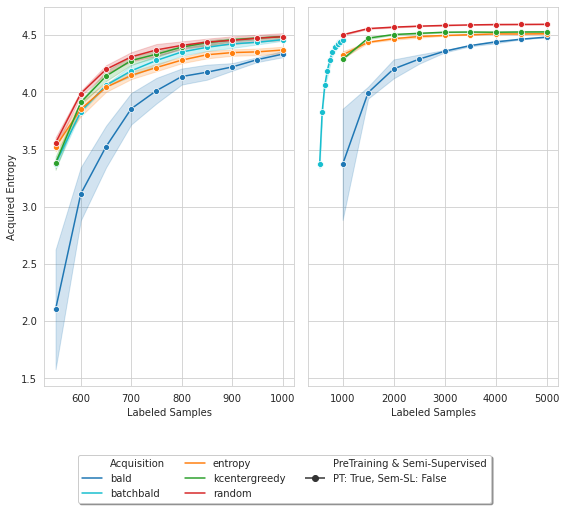

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-Sem-SL.pdf


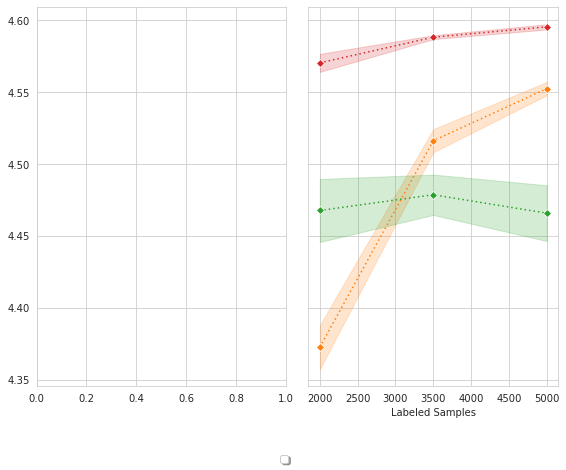

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-Self-Sem-SL.pdf


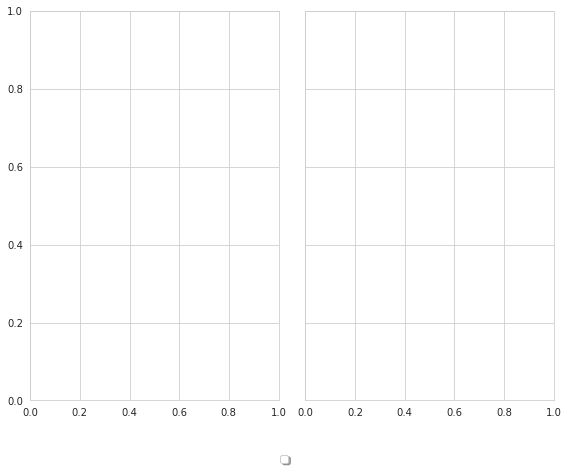

Filename:plot-bblow_train-all.pdf


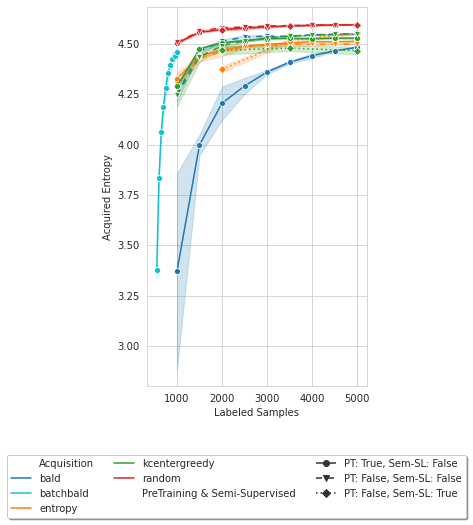

Filename:plot-bblow_train-basic.pdf


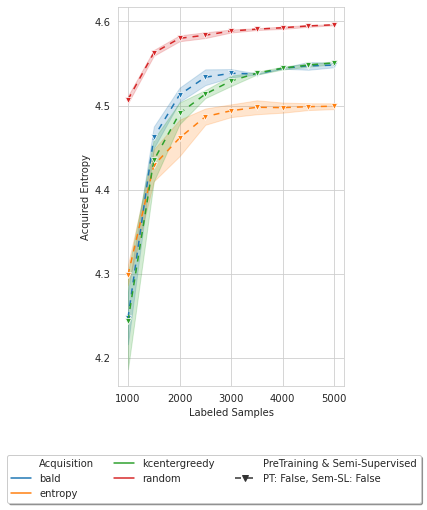

Filename:plot-bblow_train-Self-SL.pdf


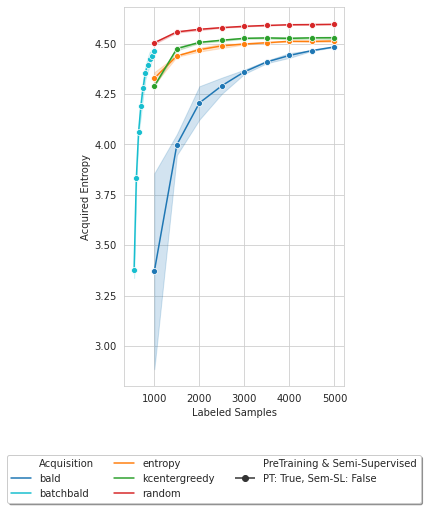

Filename:plot-bblow_train-Sem-SL.pdf


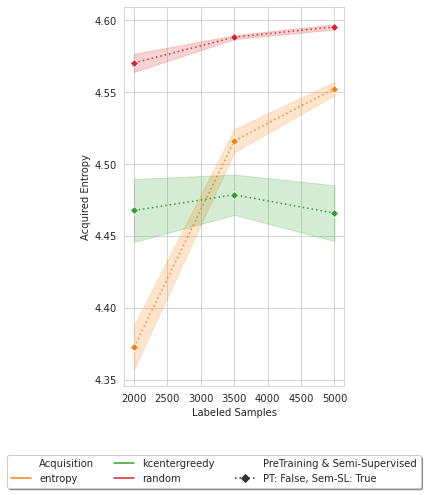

No handles with labels found to put in legend.


Filename:plot-bblow_train-Self-Sem-SL.pdf


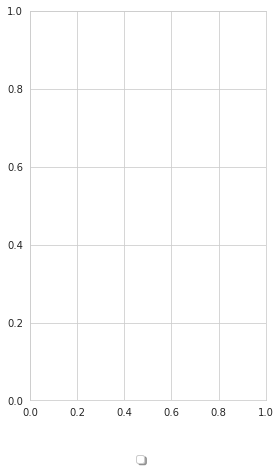

Filename:plot-full_train-all_yshared-True_bound-False.pdf


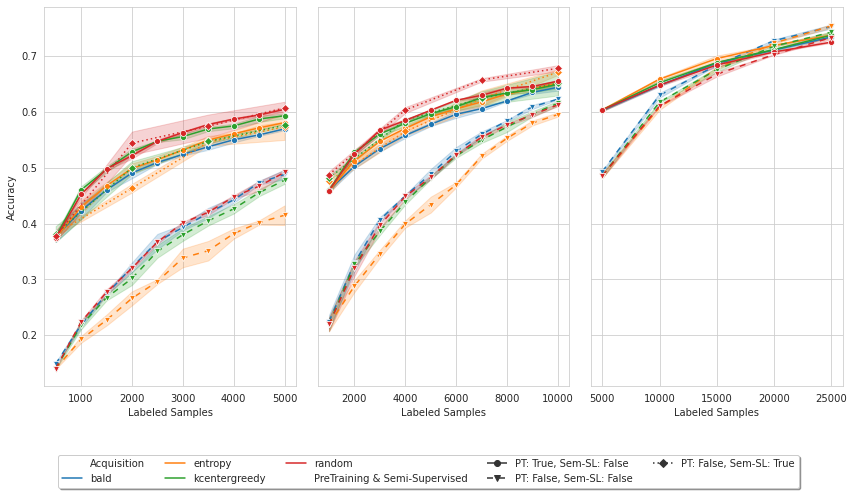

Filename:plot-full_train-basic_yshared-True_bound-False.pdf


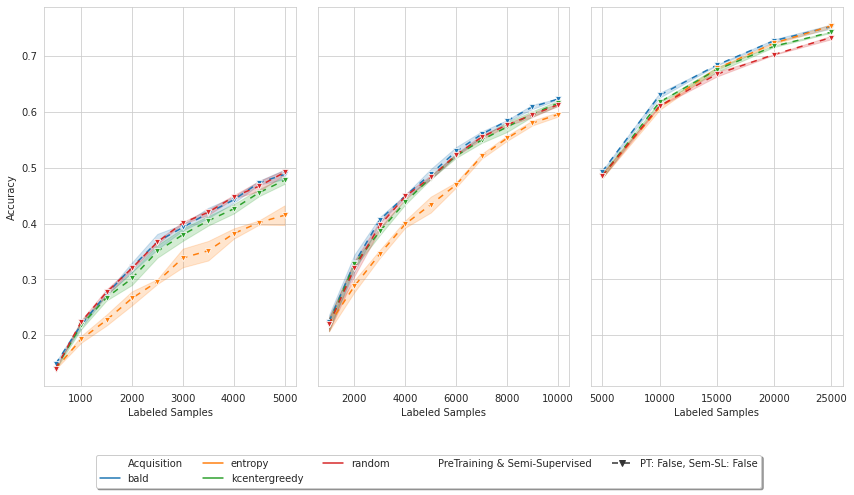

Filename:plot-full_train-Self-SL_yshared-True_bound-False.pdf


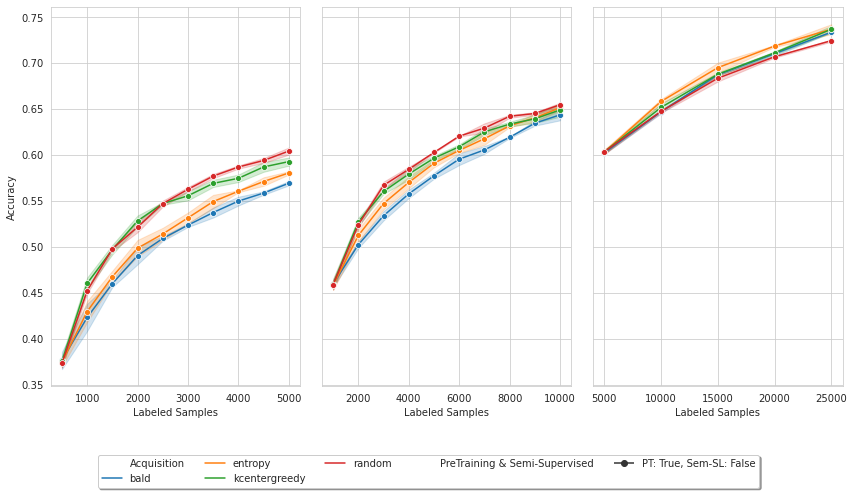

Filename:plot-full_train-Sem-SL_yshared-True_bound-False.pdf


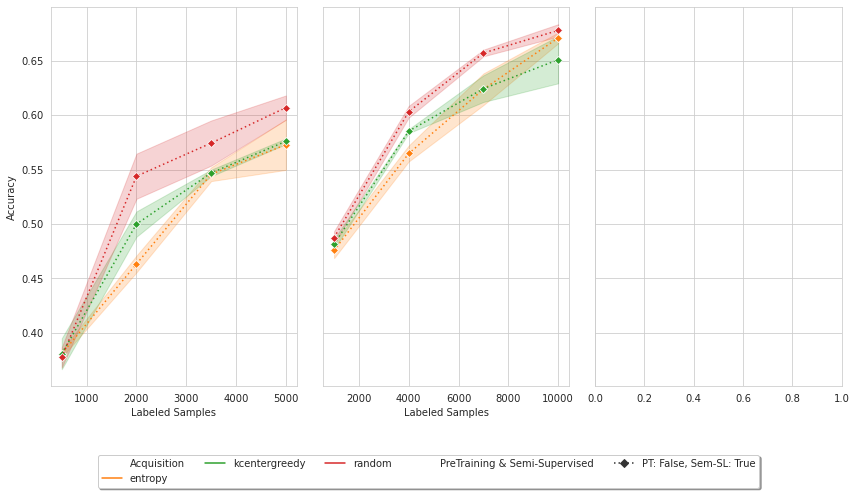

No handles with labels found to put in legend.


Filename:plot-full_train-Self-Sem-SL_yshared-True_bound-False.pdf


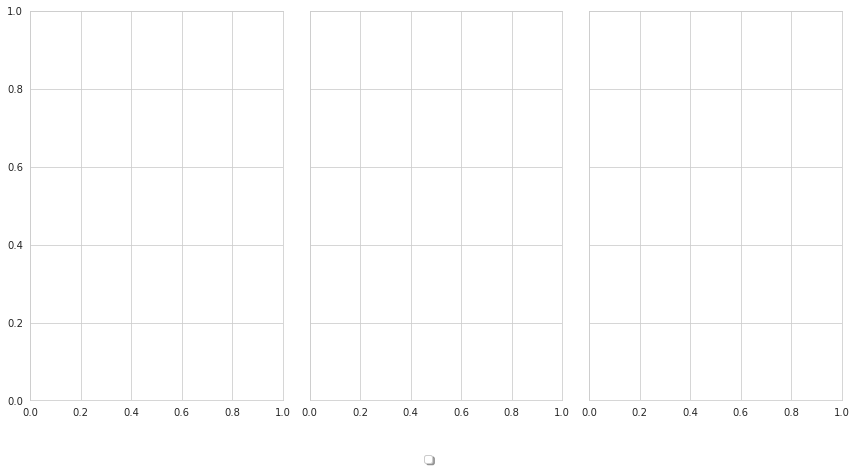

Filename:plot-low-bb_train-all_yshared-True_bound-False.pdf


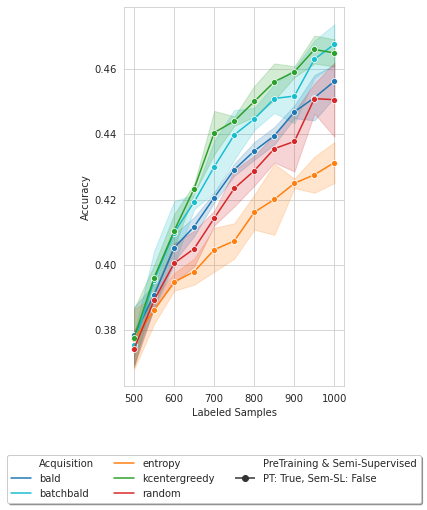

No handles with labels found to put in legend.


Filename:plot-low-bb_train-basic_yshared-True_bound-False.pdf


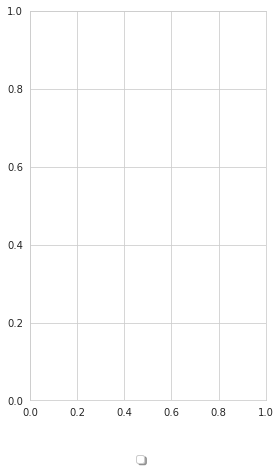

Filename:plot-low-bb_train-Self-SL_yshared-True_bound-False.pdf


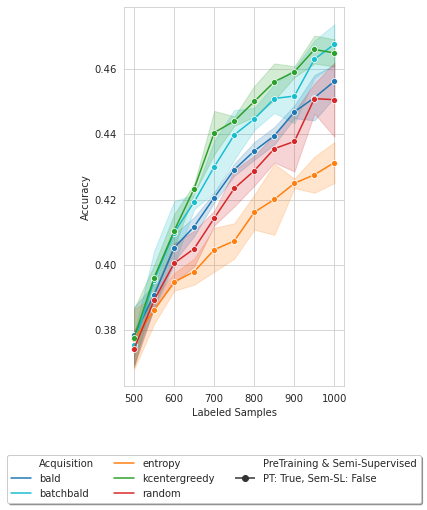

No handles with labels found to put in legend.


Filename:plot-low-bb_train-Sem-SL_yshared-True_bound-False.pdf


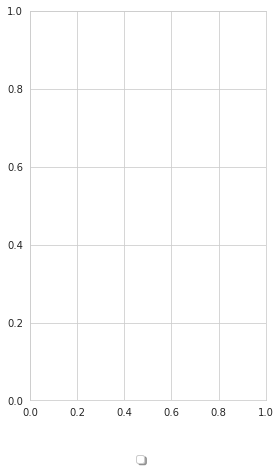

No handles with labels found to put in legend.


Filename:plot-low-bb_train-Self-Sem-SL_yshared-True_bound-False.pdf


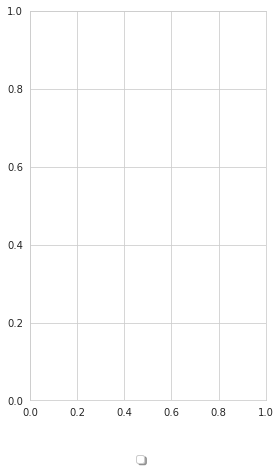

Filename:plot-low-bb-fulll_train-all_yshared-True_bound-False.pdf


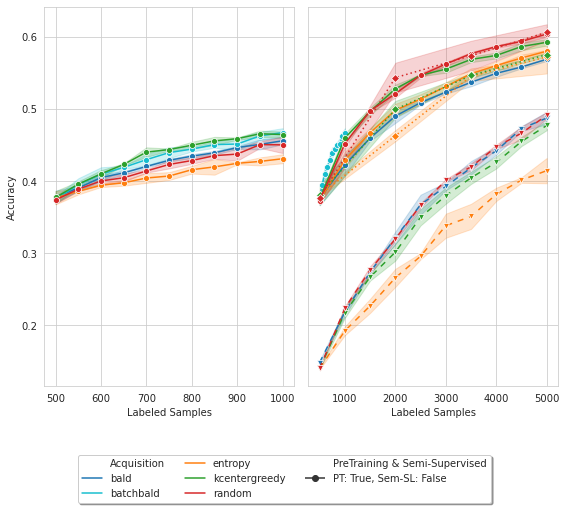

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-basic_yshared-True_bound-False.pdf


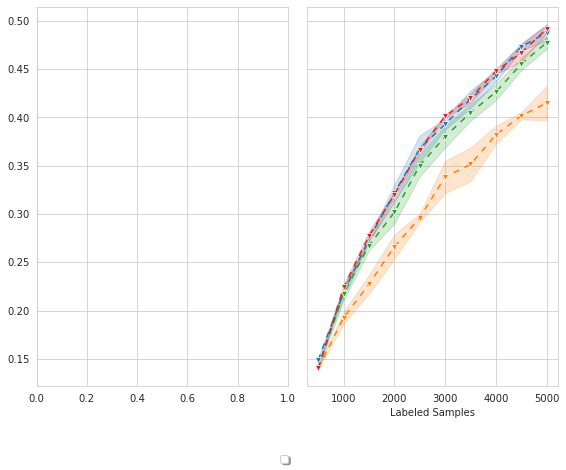

Filename:plot-low-bb-fulll_train-Self-SL_yshared-True_bound-False.pdf


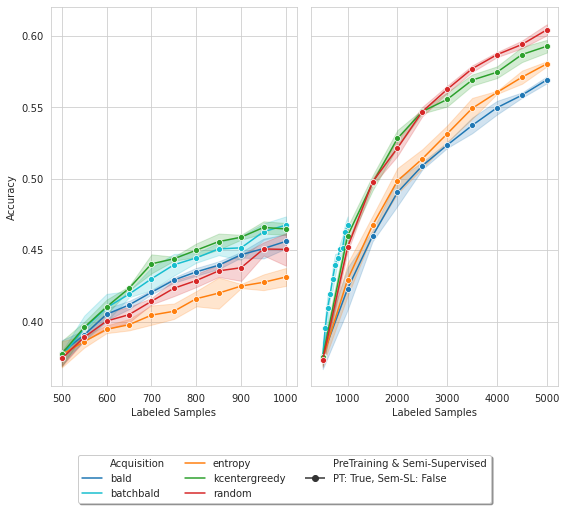

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-Sem-SL_yshared-True_bound-False.pdf


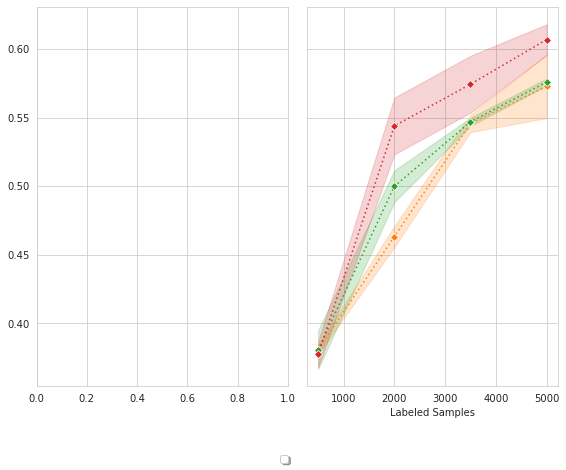

No handles with labels found to put in legend.


Filename:plot-low-bb-fulll_train-Self-Sem-SL_yshared-True_bound-False.pdf


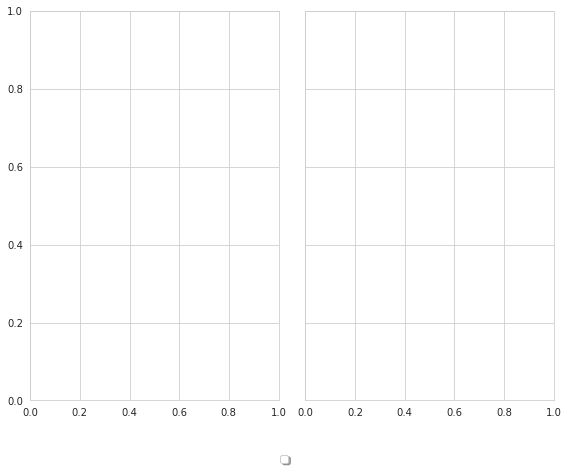

Filename:plot-bblow_train-all_yshared-True_bound-False.pdf


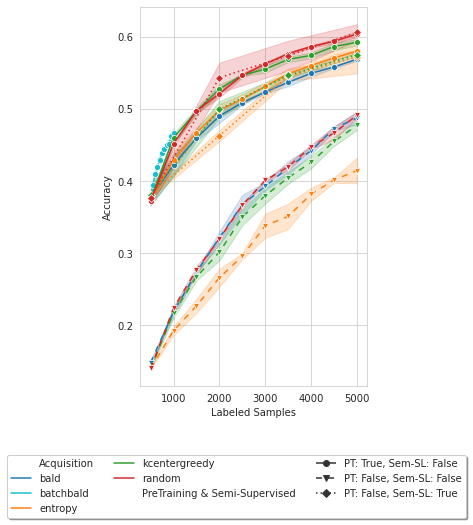

Filename:plot-bblow_train-basic_yshared-True_bound-False.pdf


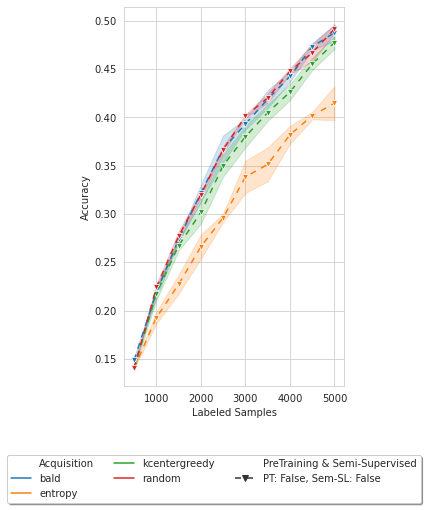

Filename:plot-bblow_train-Self-SL_yshared-True_bound-False.pdf


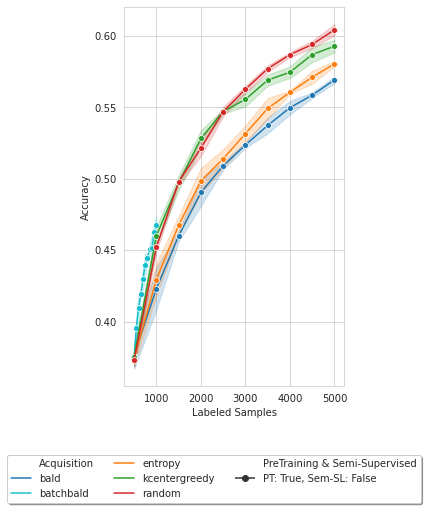

Filename:plot-bblow_train-Sem-SL_yshared-True_bound-False.pdf


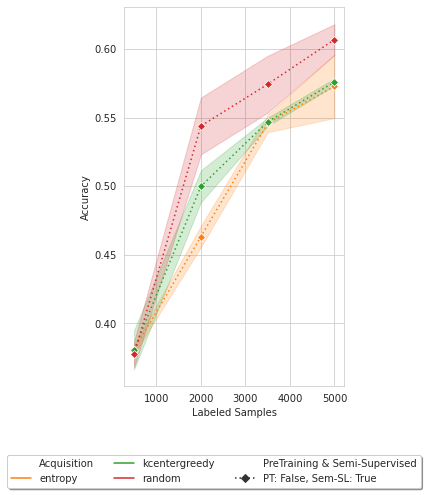

No handles with labels found to put in legend.


Filename:plot-bblow_train-Self-Sem-SL_yshared-True_bound-False.pdf


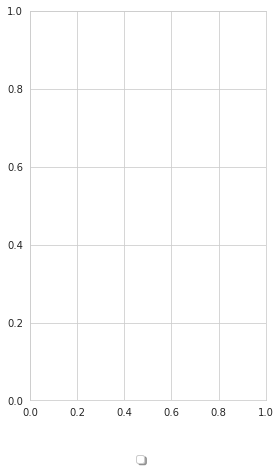

Filename:plot-full_train-all_yshared-False_bound-True.pdf


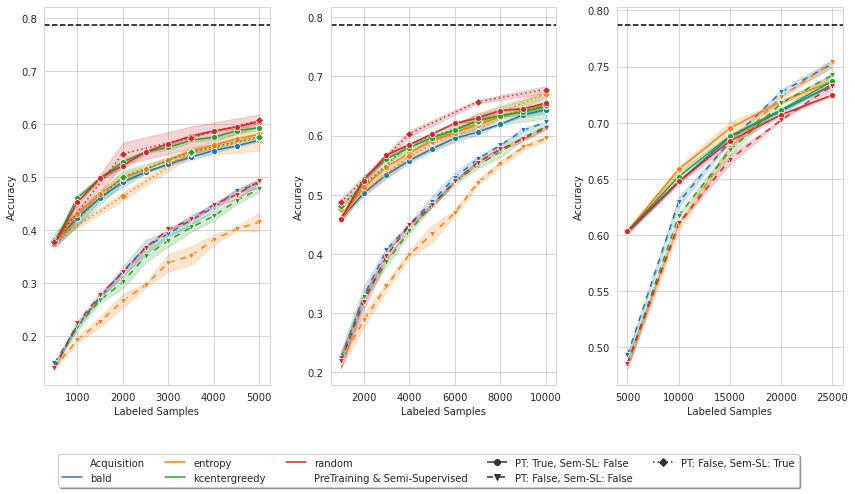

Filename:plot-full_train-basic_yshared-False_bound-True.pdf


In [ ]:
from itertools import product
plot_values = {
    "Accuracy" : "test_acc",
    "Balanced Accuracy" : "test/w_acc",
    "Batch Entropy" : "Acquisition Entropy",
    "Acquired Entropy" : "Dataset Entropy",
}
upper_bounds = [True, False]
y_shareds = [True, False]


for y_shared, upper_bound in product(upper_bounds, y_shareds):
    for plot_val ,plot_key in plot_values.items():
        if plot_val in ["Batch Entropy", "Acquired Entropy"]:
            if not (y_shared and upper_bound):
                continue
                
        for setting in setting_dfs:
            dfs = setting_dfs[setting]
            if plot_key in dfs[0]:
                for training_setting, training_styles in training_settings.items():
                    num_cols = len(dfs)
                    ax_legend = 0
                    fig, axs = plt.subplots(ncols=num_cols, sharey=y_shared)
                    if num_cols == 1:
                        axs = [axs]
                    if style_vals is None:
                        style_name = None
                    if unit_vals is None:
                        unit_name = None

                    for i in range(num_cols):
                        df = dfs[i][dfs[i][style_name].isin(training_styles)]
                        if len(df) == 0:
                            continue
                        ax = axs[i]

                        legend = False
                        if i == ax_legend:
                            legend = 'auto'
                        ax = plot_standard_dev(
                            ax, df, y=plot_key, hue=hue_name, style=style_name, units=unit_name, ci = 'sd', legend=legend , palette=palette, markers=markers,
                            dashes=dashes,
                            err_kws={"alpha":0.2}
                        )  # , units=unit_name)
                        full_dict = {
                            "Basic": {"color":"black", "linestyle":'--' },
                            "PT" : {"color":"black", "linestyle":'- ' },
                        }
                        if upper_bound:
                            for model in full_dict:
                                if model in full_data_dict:
                                    if plot_key in full_data_dict[model]:
                                        ax.axhline(full_data_dict[model][plot_key]["mean"]/100, **full_dict[model])
                        ax.set_xlabel("Labeled Samples")
                        ax.set_ylabel(plot_val)
                        if i == ax_legend:
                            ax.get_legend().remove()
                    # fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
                    #           ncol=3, fancybox=True, shadow=True)
                    # fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    if num_cols == 3:
                        ncol_legend = 5
                    else:
                        ncol_legend = 3
                    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                              fancybox=True, shadow=True, ncol=ncol_legend)

                    fig.set_size_inches(4*num_cols, 6)
                    fig.tight_layout()
                    save_dir = savepath/ dataset / plot_val.replace(" ", "-")
                    if not save_dir.is_dir():
                        save_dir.mkdir(parents=True)
                    if upper_bound is True and y_shared is True:
                        fn = f"plot-{setting}_train-{training_setting}.pdf"
                    else:
                        fn = f"plot-{setting}_train-{training_setting}_yshared-{y_shared}_bound-{upper_bound}.pdf"
                    print(f"Filename:{fn}")
                    plt.savefig(save_dir/fn, bbox_inches='tight')
                    plt.show()

In [ ]:
dfs[i][style_name].isin(hue_settings)

## Path Selection

In [ ]:
dfs[0]

In [ ]:
from IPython.display import HTML

In [ ]:
val_df = dfs[0].loc[:, [col for col in dfs[0].columns if "test/rec" in col or col =="num_samples"] ]
val_df
# dfs[0].columns[0]
HTML(val_df.groupby("num_samples").mean().to_html(classes='table table-stripped'))

In [ ]:
test = [x for x in range(10) if x%2 ==0]
test

## Obtain Numerical Results

In [ ]:
metric = "test_acc"

In [ ]:
df = dfs[0]
df_random = df[df["Name"]=="random"]
# df_random = df.loc[:, ["test_acc", "num_samples", "PreTraining & Semi-Supervised"]]

In [ ]:
for i in range(len(dfs)):
    df = dfs[i]
    df_random = df[df["Name"]=="random"]
    df_random = df_random.groupby(["num_samples", "PreTraining & Semi-Supervised"], ).agg({metric : ['mean', 'std']}).round(4)*100
    print(base_paths[i])
    print(df_random)